# ArcGIS y Modelos LLM

Proponemos la integración de modelos GPT, (como los disponibles en OpenAI, Google, Huggingface, ollama, azure, etc.) con ArcGIS Online, una potente plataforma de colaboración para el análisis espacial, la cartografía y la visualización de datos. 

El objetivo de esta integración es proporcionar a la comunidad ArcGIS una aplicación de chat inteligente capaz de responder preguntas, generar tutoriales, proporcionar fragmentos de código y transmitir las mejores prácticas. Al aprovechar las capacidades de ChatGPT, los usuarios pueden acceder a una gran cantidad de conocimientos y recibir orientación en tiempo real, lo que se traduce en una mayor eficiencia y una mejor formación continua para los profesionales de los SIG.

Es responsabilidad de cada usuario revisar lo entregado por el modelo, aún se encuentran en desarrollo 😉

<div style="text-align: center;">
  <img src="https://github.com/iyanez-esrichile/CU2025/blob/main/sources/Gemini_Generated_Image.jpg" width="30%" alt="Descripción de la imagen"/>
</div>


## 1. Metodología de trabajo

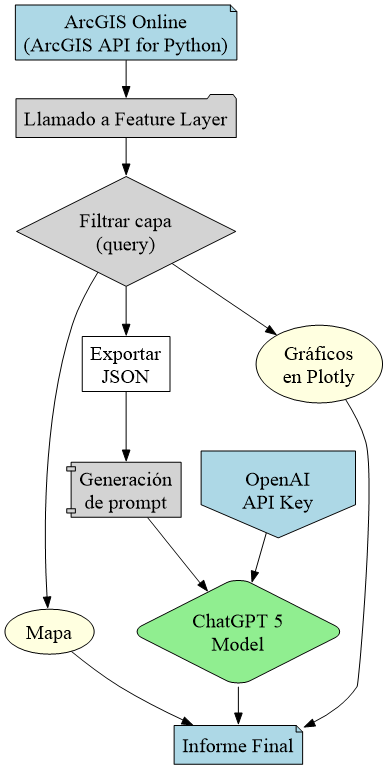

In [234]:
from graphviz import Digraph
from IPython.display import Image, display

# Crear diagrama
dot = Digraph("Flujo CDR 2025", format="png")
dot.attr(rankdir="TB", size="8")

dot.node("A", "ArcGIS Online \n(ArcGIS API for Python)", shape="note", style="filled", fillcolor="lightblue")
dot.node("J", "Llamado a Feature Layer",shape="folder", fillcolor="lightgray",style="filled")
dot.node("B", "Filtrar capa \n(query)",shape="diamond", fillcolor="lightgray",style="filled")
dot.node("C", "Mapa", shape="ellipse", fillcolor="lightyellow",style="filled")
dot.node("D", "Exportar\nJSON", shape="box")
dot.node("E", "Generación\nde prompt",style="rounded,filled", shape="component")
dot.node("F", "ChatGPT 5\nModel", style="rounded,filled", shape="diamond", fillcolor="lightgreen")
dot.node("G", "Gráficos\nen Plotly", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("H","Informe Final", fillcolor="lightblue",style="filled", shape="note")
dot.node("I","OpenAI\nAPI Key", fillcolor="lightblue",style="filled", shape="invhouse")

dot.edges(["AJ", "JB","BC", "BD","BG", "DE","EF","FH","GH","CH","IF"])

# Renderizar en memoria y mostrar directamente en output
png_bytes = dot.pipe(format='png')
display(Image(png_bytes))


## 2. Insumos para codigo (API Keys, usuarios, etc..)

In [235]:
from openai import OpenAI
client = OpenAI()

In [236]:
import os
import sys
from arcgis.gis import GIS
from arcgis.features import FeatureLayer,GeoAccessor, GeoSeriesAccessor
from dotenv import load_dotenv
import pandas as pd


In [237]:
load_dotenv()

portal_url = os.getenv("ARCGIS_PORTAL_URL", "https://www.arcgis.com").strip()
username = os.getenv("ARCGIS_USERNAME")
password = os.getenv("ARCGIS_PASSWORD")

try:
    # use "home" if you have a saved profile (ArcGIS Pro/AGO Notebook), or pass url/user/pass
    gis = GIS(portal_url, username, password)
    # gis = GIS("home")

    # This call hits the portal and will raise if unreachable/bad creds
    host = gis.properties.portalHostname
    me = gis.users.me

    print(f"Connected to: {host}")
    if me:
        print(f"Logged in as: {me.username}")
    else:
        print("Connected anonymously.")
except Exception as ex:
    print(f"Connection failed: {ex}")


Connected to: www.arcgis.com
Logged in as: iyanez_esricldemo


## 3. Llamada de Feature Layer desde ArcGIS Online

In [238]:
# Opción A: buscar por título
items = gis.content.search('title:"Catastro Relaves SNGM 2024"', item_type="Feature Layer")
if not items:
    raise Exception("No se encontró un ítem con título 'CDR 2024'.")
flayer = items[0].layers[0]  # si el servicio tiene varias subcapas, ajusta el índice o compara por nombre

In [252]:
map1 = gis.map("chile")
map1.content.add(flayer)
map1.basemap.basemap = 'satellite'
map1

Map(center=[-3503549.843504369, -7903683.846322417], extent={'xmin': -10211336.890466979, 'ymin': -6573672.101…

In [253]:
map1.legend.enabled = True

## 4. Consulta (Query) y Generación de Mapa

In [241]:
where="PROVINCIA='Quillota'"
fs = flayer.query(where=where, out_fields="*")
sdf = fs.sdf  # aquí ya no intenta convertir geometrías
sdf.head()

,OBJECTID,ID,RUT_EMPRESA_O_PRODUCTOR_MINERO,NOMBRE_EMPRESA_O_PRODUCTOR_MINE,NOMBRE_FAENA,REGION,PROVINCIA,COMUNA,NOMBRE_INSTALACION,TIPO_DEPOSITO,...,VOL_AUTORIZADO,VOL_ACTUAL,TONELAJE_AUTORIZADO,TONELAJE_ACTUAL,RES_APRUEBA,FECHA_RES_APRUEBA,RES_PDC_APRUEBA,FECHA_RES_PDC,GlobalID,SHAPE
0,713,0678-5C,7444635-3,ALEJANDRO LOPEZ ALIAGA,PLANTA VETA DEL AGUA,V,QUILLOTA,NOGALES,VETA DEL AGUA 1-2-3-4,EMBALSE,...,1565000,S/I,2347500,S/I,S/I,S/I,S/I,S/I,09d5f8c2-38cf-4a4d-8f16-cf1c0627376d,"{""x"": 300150.41170000006, ""y"": 6381689.5236, ""..."
1,714,0679-5C,7444635-3,ALEJANDRO LOPEZ ALIAGA,PLANTA VETA DEL AGUA,V,QUILLOTA,NOGALES,VETA DEL AGUA 5,EMBALSE,...,82620,S/I,123930,S/I,456,1989-04-26 00:00:00,S/I,S/I,89fe51e0-74b1-43ac-bab9-a6bb934fa50c,"{""x"": 300382.18709999975, ""y"": 6381748.2613, ""..."
2,715,0680-5C,7444635-3,ALEJANDRO LOPEZ ALIAGA,PLANTA VETA DEL AGUA,V,QUILLOTA,NOGALES,VETA DEL AGUA 6,EMBALSE,...,358795,"318222,666666667",538192,477334,1784,2011-06-20 00:00:00,S/I,S/I,8bcf1318-9b08-4b11-b401-1d90e316f7a8,"{""x"": 299810.68599999975, ""y"": 6381894.3115, ""..."
3,729,0694-5C,77762940-9,ANGLO AMERICAN SUR S.A.,EL SOLDADO,V,QUILLOTA,NOGALES,EL COBRE 1,TRANQUE DE RELAVE,...,2350000,S/I,3525000,S/I,S/I,S/I,2417,2015-09-29 00:00:00,c1134689-a8de-478a-b178-6736e9603bea,"{""x"": 298693.9406000003, ""y"": 6384007.0145, ""s..."
4,730,0695-5C,77762940-9,ANGLO AMERICAN SUR S.A.,EL SOLDADO,V,QUILLOTA,NOGALES,EL COBRE 2,TRANQUE DE RELAVE,...,1000000,S/I,1500000,S/I,S/I,S/I,2417,2015-09-29 00:00:00,aba4916d-1c2b-414a-b531-0855c9b4c461,"{""x"": 298891.7893000003, ""y"": 6383499.9069, ""s..."


In [242]:
map2 = gis.map()
map2.content.add(fs)
map2.basemap.basemap = 'satellite'
map2.zoom_to_layer(fs)
map2

Map(extent={'xmin': -7926558.882434142, 'ymin': -3904435.892074716, 'xmax': -7906017.6481628055, 'ymax': -3847…

## 5. Exportación de JSON

In [243]:
json_str = sdf.to_json(orient="records")

## 6. Construcción del prompt

In [ ]:
from IPython.display import display, Markdown

def show_response(response):
    # Obtener contenido
    texto = response.choices[0].message.content

    display(Markdown(texto))

In [254]:
prompt = f"""
Tengo un dataset de CDR_2024 en formato JSON:
{json_str}

Quiero que me ayudes a:
1. Analizar tendencias de depositos de relaves en este caso en {where} en Chile, TIPO_DEPOSITO y ESTADO_INSTALACION"
utilizar el analisis temporal con el campo FECHA_RES_APRUEBA. ademas hay información relacionada con el plan de cierre
incluir empresa predominante por tipo de relaves
"""

In [256]:
# Llamada al chat
response = client.chat.completions.create(
    model="gpt-5",
    messages=[{"role": "user", "content": prompt}],
)

# Acceder al contenido correctamente
show_response(response)


Aquí tienes un resumen analítico de los depósitos en la provincia de Quillota (según el JSON que compartiste), enfocado en TIPO_DEPOSITO, ESTADO_INSTALACION, evolución temporal (FECHA_RES_APRUEBA) y antecedentes de Plan de Cierre (PDC), incluyendo la empresa predominante por tipo.

Resumen del universo analizado
- Registros totales: 11
- Comunas: mayormente Nogales (núcleo minero), además La Calera y Olmué.
- Estados: Activos 2, Inactivos 7, Abandonados 2.

1) Distribución por tipo de depósito y estado
- Tranque de relave (6):
  - Activo: 1 (Torito – Anglo American Sur S.A.)
  - Inactivo: 4 (El Cobre 1–3 y Tranque 4 – Anglo)
  - Abandonado: 1 (Ramayana 1 – Desconocido)
  - Volumen autorizado total: 214.564.666 m3 (domina “Torito” con 156.666.666 m3)
- Embalse (3):
  - Activo: 1 (Veta del Agua 6 – Alejandro López Aliaga)
  - Inactivo: 2 (Veta del Agua 1–4 y 5)
  - Volumen autorizado total: 2.006.415 m3
- Acopio (2):
  - Inactivo: 1 (Proquimin – Caolín)
  - Abandonado: 1 (Ramayana 2 – Desconocido)
  - Volumen autorizado total: 11.100 m3

2) Análisis temporal (FECHA_RES_APRUEBA)
- 1989: Embalse (Veta del Agua 5)
- 1995: Acopio (Proquimin)
- 2007: Tranque de relave (Tranque 4 – Anglo)
- 2011: Embalse (Veta del Agua 6)
- 2015: Tranque de relave (Torito – Anglo)
Notas:
- Hay varios “S/I” (sin información), por lo que el análisis temporal es indicativo.
- La secuencia sugiere: instalaciones más pequeñas/antiguas (embalses y acopios) desde fines de los 80/90; desde 2007 aparecen/regularizan grandes tranques de relaves de cobre (faena El Soldado, Anglo), con un hito relevante en 2015 (Torito).

3) Planes de Cierre (PDC)
- Con PDC aprobado: 5/11 (todos de Anglo en tranques de relave)
  - 2009-06-30: Tranque 4 y Torito (RES_PDC_APRUEBA 1244)
  - 2015-09-29: El Cobre 1–3 (RES_PDC_APRUEBA 2417)
- Sin PDC registrado:
  - Embalses (3/3, Alejandro López Aliaga)
  - Acopios (2/2, Proquimin y Desconocido)
  - Ramayana 1 (TR abandonado)
Implicancia: En tranques de relaves, la cobertura de PDC es alta (5 de 6, 83,3%), impulsada por Anglo. En embalses y acopios no hay PDC registrado en los datos.

4) Empresa predominante por tipo de depósito
- Tranque de relave: Anglo American Sur S.A. (5 de 6; el restante es “Desconocido” y está abandonado).
- Embalse: Alejandro López Aliaga (3 de 3, todos de oro).
- Acopio: sin predominio (1 Proquimin – caolín, 1 Desconocido – cobre).

5) Observaciones y tendencias clave
- Concentración espacial y corporativa:
  - Nogales concentra prácticamente todos los tranques de relaves y embalses. Anglo (faena El Soldado) domina los tranques, con fuerte presencia y PDCs aprobados (2009 y 2015).
  - La Calera (acopio no metálico – Proquimin) y Olmué (sitios “Ramayana”, ambos abandonados) aparecen como casos más pequeños o antiguos.
- Estado operacional:
  - Solo 2 activos en la provincia: Torito (TR, cobre, método eje central) y Veta del Agua 6 (embalse, oro). El resto son inactivos o abandonados.
- Evolución tecnológica/seguridad en tranques:
  - Los tranques inactivos más antiguos usan “aguas arriba/abajo”; el único activo (Torito) usa “eje central”, consistente con prácticas más conservadoras.
- Magnitud de impacto potencial:
  - Los volúmenes autorizados muestran una diferencia de escala: los tranques (especialmente Torito) superan ampliamente a embalses y acopios. Esto concentra el riesgo operativo y de cierre en los activos de Anglo.
- Brechas de información:
  - Múltiples “S/I” en fechas de aprobación y PDC para embalses y acopios. Podría ser falta de regularización histórica o ausencia de actualización en la base.

Sugerencias rápidas de seguimiento
- Verificar y actualizar FECHA_RES_APRUEBA y PDC en embalses de “Veta del Agua” y acopios, dado que hoy no registran PDC.
- Monitorear el cumplimiento PDC en Torito y su avance vs. VOL_ACTUAL (123,3 millones m3) y TONELAJE_ACTUAL (201,2 millones t).
- Revisar pasivos abandonados “Ramayana” (Olmué): no tienen resoluciones ni PDC; priorizar diagnóstico ambiental y de estabilidad.

Si quieres, puedo convertir esto en un pequeño dashboard (por ejemplo, conteos por tipo/estado, línea de tiempo por año, mapa por comuna) o darte el código para reproducir el análisis con Python/Pandas.

## 7. Construcción de Gráficas

In [247]:
import json
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html

# --- Dashboard Plotly ---

# 1️⃣ Histograma de instalaciones por Región
fig_region = px.histogram(
    sdf,
    x='REGION',
    title="Número de instalaciones por Región",
    color='ESTADO_INSTALACION'
)


# 2️⃣ Histograma por Recurso
fig_recurso = px.histogram(
    sdf,   x='RECURSO',
    title="Número de instalaciones por Recurso",
    color='ESTADO_INSTALACION'
)


# 3️⃣ Sunburst de Recurso → Estado
fig_estado = px.sunburst(
    sdf,   path=['RECURSO','ESTADO_INSTALACION'],
    title="Estado de las instalaciones por Recurso"
)

In [248]:
from dash import Dash, dcc, html

# --- Exportar MapView a HTML ---
file_dir = os.path.join(os.getcwd(), 'home') 
os.makedirs(file_dir, exist_ok=True)
file_path = os.path.join(file_dir, 'relaves.html')
map1.zoom_to_layer(fs)

# Exportar el mapa a HTML
map1.export_to_html(file_path)  # solo guarda el archivo

# Leer el HTML como string para usar en Dash
with open(file_path, 'r', encoding='utf-8') as f:
    map1_html = f.read()

# --- Dash App con mapa ArcGIS ---
app = Dash(__name__)
app.layout = html.Div([
    html.H1("Dashboard Catastro Relaves SNGM 2024", style={'textAlign':'center'}),

    html.Div([
        html.Div([dcc.Graph(figure=fig_region)], style={'width':'48%', 'display':'inline-block'}),
        html.Div([dcc.Graph(figure=fig_recurso)], style={'width':'48%', 'display':'inline-block'})
    ]),

    html.Div([
        html.Div([dcc.Graph(figure=fig_estado)], style={'width':'48%', 'display':'inline-block'}),
        html.Div([html.Iframe(srcDoc=map1_html, width='100%', height='445px')],
                 style={'width':'48%', 'display':'inline-block'})
    ])
])

if __name__ == '__main__':
    app.run(debug=True)

## 8. Generación de informe Final

In [249]:
import plotly.io as pio

pio.write_html(fig_region, r"./home/fig_region.html", full_html=True, include_plotlyjs='cdn')
pio.write_html(fig_recurso, r"./home/fig_recurso.html", full_html=True, include_plotlyjs='cdn')
pio.write_html(fig_estado, r"./home/fig_estado.html", full_html=True, include_plotlyjs='cdn')


In [257]:
chat_file = os.path.join(file_dir, "chat_result.html")
with open(chat_file, "w", encoding="utf-8") as f:
    f.write(f"""
    <!DOCTYPE html>
    <html lang="es">
    <head>
        <meta charset="UTF-8">
        <title>Chat GPT Result</title>
        <style>
            body {{
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.5;
                max-width: 100%;
            }}
            pre {{
                font-size: 14px;            /* tamaño de letra legible */
                white-space: pre-wrap;      /* respeta saltos de línea y ajusta al contenedor */
                word-wrap: break-word;      /* corta palabras largas */
                overflow: hidden;           /* evita scroll horizontal */
                width: 100%;                /* ocupa todo el ancho disponible */
            }}
        </style>
    </head>
    <body>
        <pre>{response.choices[0].message.content}</pre>
    </body>
    </html>
    """)

print("Chat HTML saved at:", chat_file)

Chat HTML saved at: c:\Users\iyanez\Esri Chile\Esri Chile Architecture - iniciativas\Webinar Mining IA\Gemini\home\chat_result.html
